# Lecture : Graph Generation Models

## Lab 05 : Diffusion model (DM) for mixture of Gaussians

### Xavier Bresson, Nian Liu


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/11_Graph_Generation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time
#import utils
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings
import os, datetime

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.0.1+cu118
NVIDIA GeForce RTX 4090 Laptop GPU
cuda:0


/home/bcjr1997/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Create artifical dataset of mixture of Gaussians

num_x, range_x, step_x, x :  100 20 0.40404040404040403 torch.Size([100])
num_gaussians :  2
train_data, bs, num_batch :  torch.Size([4000, 100]) 100 40
train_data :  torch.Size([4000, 100])
max, min, mean :  tensor(1.) tensor(-1.) tensor(-0.7510)


<Figure size 432x288 with 0 Axes>

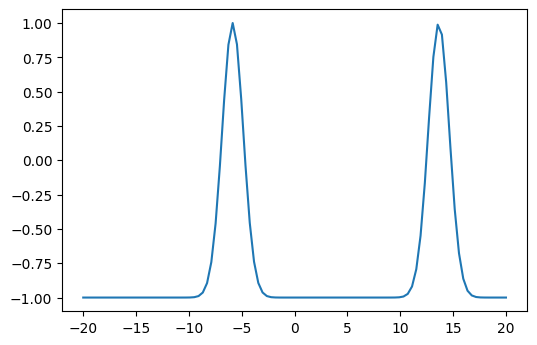

<Figure size 432x288 with 0 Axes>

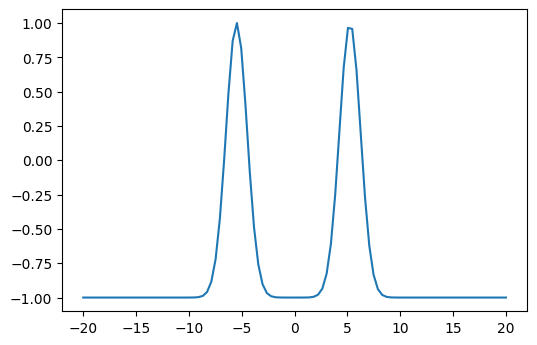

In [3]:
# Parameters of the mixture of Gaussians
num_data = 4000
num_x = 100
range_x = 20
step_x = 2 * range_x / (num_x - 1)
x = torch.arange(-range_x,range_x+step_x,step_x)
print('num_x, range_x, step_x, x : ',num_x, range_x, step_x, x.size())
num_gaussians = 2
print('num_gaussians : ', num_gaussians)
train_data = torch.zeros(num_data, num_x)
bs = 100
num_batch = num_data//bs
print('train_data, bs, num_batch : ', train_data.size(), bs, num_batch)

for k in range(num_batch):
    mu = torch.zeros(num_gaussians, bs)
    mu[0,:] = torch.FloatTensor(bs).uniform_(-15, -5)
    mu[1,:] = torch.FloatTensor(bs).uniform_(5, 15)   
    mu_batch = mu.unsqueeze(2)
    sigma = torch.ones(num_gaussians, bs)
    sigma_batch = sigma.unsqueeze(2)
    x_batch = x.repeat(num_gaussians, bs, 1)
    p = torch.exp( - (x_batch - mu_batch)**2 / (2* sigma_batch**2) ) / torch.sqrt( 2* torch.pi* sigma_batch**2 )
    p = p.sum(0); p /= p.sum(1).unsqueeze(1)
    p = ( p - p.min(1)[0].unsqueeze(1) ) / ( p.max(1)[0].unsqueeze(1) - p.min(1)[0].unsqueeze(1) )
    p = 2 * ( p - 0.5 )
    train_data[k*bs:(k+1)*bs, :] = p
print('train_data : ',train_data.size())
print('max, min, mean : ',train_data.max(), train_data.min(), train_data.mean())

plt.figure(2)
plt.figure(dpi=100)
plt.plot(x, train_data[0])
plt.show()
plt.figure(3)
plt.figure(dpi=100)
plt.plot(x, train_data[1])
plt.show()


# Diffusion model (DDPM) [1] and Transformers [2]

[1] Ho et-al, Denoising Diffusion Probabilistic Models, 2020, https://arxiv.org/pdf/2006.11239  
[2] Vaswani et-al, Attention Is All You Need, 2017, https://arxiv.org/pdf/1706.03762


In [4]:
# Global constants
N = train_data.size(0) # number of training data
n = train_data.size(1) # number of elements in the line 
print('N, n : ', N, n)

num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers = 4 # number of transformer layers
dPEt = d # number of dimensions for the time step of the diffusion model
drop = 0.01 # dropout value
bs = 50 # batch size
print('num_heads, d, num_layers, dPEt, drop, bs : ', num_heads, d, num_layers, dPEt, drop, bs)

beta_1 = 0.0001 # beta_1 for DM
beta_T = 0.02 # beta_T for DM
num_t = 150 # number of time steps of the DM
alpha_t = 1.0 - torch.linspace(beta_1, beta_T, num_t).to(device) # for DM, size=[num_t] 
alpha_bar_t = torch.cumprod( alpha_t, dim=0) # for DM, size=[num_t] 
print('beta_1, beta_T, num_t :', beta_1, beta_T, num_t)


N, n :  4000 100
num_heads, d, num_layers, dPEt, drop, bs :  4 128 4 128 0.01 50
beta_1, beta_T, num_t : 0.0001 0.02 150


In [5]:
# Define DDPM architecture with Transformers
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
    def forward(self, x):
        Q = self.Q(x)      # [bs, n, d_head]
        K = self.K(x)      # [bs, n, d_head]
        V = self.V(x)      # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        Att = (Q * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)        # [bs, n, n]
        Att = self.drop_att(Att) # [bs, n, d_head]
        x = Att @ V              # [bs, n, d_head]
        return x

class MHA(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
    def forward(self, x):
        x_MHA = []  
        for head in self.heads:
            x_HA = head(x)                    # [bs, n, d_head]
            x_MHA.append(x_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        return x

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
        self.mu = nn.Linear(d, d, bias=True)
    def forward(self, x):
        x_in = x                        # [bs, n, d]
        x = self.LNx(x)                 # [bs, n, d]
        x_MHA = self.MHA(x)             # [bs, n, d]
        x = x_in + x_MHA                # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pe_t_emb = nn.Sequential(nn.Embedding(num_t, dPEt), nn.ReLU(), nn.Linear(dPEt, d))
        self.pe_x = nn.Embedding(n, d)
        self.x_emb = nn.Linear(1, d)
        self.gt_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers)] )
        self.ln_final = nn.LayerNorm(d)  
        self.linear_final = nn.Linear(d, 1)
        self.drop_x_emb = nn.Dropout(drop)
        self.drop_p_emb = nn.Dropout(drop)
    def forward(self, x_t, sample_t):
        x_t = self.x_emb(x_t.unsqueeze(2)) # [bs, n, d]
        bs2 = x_t.size(0)
        pe_x = torch.arange(0,n).to(device).repeat(bs2,1) # [bs, n] 
        pe_x = self.pe_x(pe_x)             # [bs, n, d] 
        x_t = x_t + pe_x                   # [bs, n, d]
        p_t = self.pe_t_emb(sample_t)      # [bs, d]
        x_t = self.drop_x_emb(x_t)         # [bs, n, d]
        p_t = self.drop_p_emb(p_t)         # [bs, d]
        for gt_layer in self.gt_layers:
            x_t = x_t + p_t.unsqueeze(1)   # [bs, n, d]
            x_t = gt_layer(x_t)            # [bs, n, d]
        # output
        x_t = self.ln_final(x_t)           # [bs, n, d]
        x_t_minus_one = self.linear_final(x_t).squeeze()  # [bs, n]
        return x_t_minus_one

# Question 1: Implement the DDPM architecture

#### Step 1: Define the weights $\alpha_t$ and $\bar{\alpha_t}$
- Their lengths are the same as the number of timesteps $T$.

#### Step 2: Code the forward diffusion process
- Jump from $x_0$ to $x_t$ in one step.
\begin{eqnarray*}
    x_t = \sqrt{\bar{\alpha_t}}x_0+\sqrt{1-\bar{\alpha_t}}\epsilon_0, \textrm{where } \epsilon_0\sim\mathcal{N}(0, I)
\end{eqnarray*}

#### Step 3: Implement the backward denosing process
Given the current step sample $x_t$ and $t$, predict the noise $\epsilon$ with a transformer network.

#### Step 4: Code the generation process
- Randomly sample from $x_T\sim\mathcal{N}(0, I)$.
- Generate $x_{t-1}$ given $x_t$ following the distribution $p(x_{t-1}|x_t, x_0)=\mathcal{N}(\mu_t, \sigma_t^2)$, where:
\begin{eqnarray*}
    &&\mu_t = \frac{1}{\sqrt{\alpha_t}}(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}
    \epsilon_\theta(x_t, t)),\\
    &&\sigma^2_t = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha_t}}\\
    \textrm{So, } &&x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}
    \epsilon_\theta(x_t, t))+\sigma_t z, \textrm{where } z\sim\mathcal{N}(0, I).
\end{eqnarray*}
We recurrently calculate $x_{t-1}$ until $x_0$.


In [6]:
class DDPM(nn.Module):

    def __init__(self, num_t, beta_1, beta_T):
        super().__init__()
        self.num_t = num_t
        ###############################################
        # Define alpha_t and alpha_bar_t
        # YOUR CODE STARTS
        ###############################################
        self.alpha_t = torch.linspace(beta_1, beta_T, num_t).to(device) # [num_t]
        self.alpha_bar_t = torch.cumprod(self.alpha_t, dim=0) # [num_t]
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        self.UNet = UNet()

    def forward_process(self, x0, sample_t, noise_x0): # add noise
        ###############################################
        # x_0 -> x_t 
        # YOUR CODE STARTS
        ###############################################
        bs_sample_t = sample_t.size(0)
        sqrt_alpha_bar_t = torch.sqrt(self.alpha_bar_t[sample_t]) # [bs] Sample at T
        minus_sqrt_alpha_bar_t = torch.sqrt(1 - self.alpha_bar_t[sample_t]) # [bs] Sample at T
        x_t = sqrt_alpha_bar_t.view(bs_sample_t, 1) + minus_sqrt_alpha_bar_t.view(bs_sample_t, 1) * noise_x0 # [bs, n]
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return x_t

    def backward_process(self, x_t, sample_t):   
        ###############################################
        # Predict noise at timestep t
        # YOUR CODE STARTS
        ###############################################
        noise_pred_x_t = self.UNet(x_t, sample_t)  # [bs, n]
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return noise_pred_x_t

    def generate_process_ddpm(self, num_mol):
        t = num_t - 1
        bs = num_mol
        batch_t = (t * torch.ones(bs)).long().to(device)
        batch_x_t = torch.randn(bs, n).to(device) # t=T => t=T-1 in python
        set_t = list(range(t-1,0,-1)); set_t = set_t + [0]
        for t_minus_one in set_t: # for t=T,T-step_size,T-2*step_size,...,step_size,0
            batch_t_minus_one = (t_minus_one * torch.ones(bs)).long().to(device)
            ###############################################
            # x_t, t -> x_t-1
            # YOUR CODE STARTS
            ###############################################
            alpha_t, alpha_bar_t, prev_alpha_bar_t = self.alpha_t[t], self.alpha_bar_t[t], self.alpha_bar_t[t_minus_one]
            noise_xt_t = self.backward_process(batch_x_t, batch_t) # Predict Noise
            mu_t = (1 / torch.sqrt(alpha_t)) * (batch_x_t - ((1 - alpha_t) / (1 - alpha_bar_t)) * noise_xt_t)
            var_t = ((1 - alpha_t) * (1 - prev_alpha_bar_t )) / (1 - alpha_t)
            std_t = torch.sqrt(var_t)
            z = torch.randn(bs, n).to(device) # z
            batch_x_t_minus_one = mu_t + std_t * z
            ###############################################
            # YOUR CODE ENDS
            ############################################### 
            t = t_minus_one
            batch_x_t = batch_x_t_minus_one
            batch_t = batch_t_minus_one
        return batch_x_t

# Question 2: Code the training loss of DDPM

Hint:
- Calculate the MSE loss between the injected noise during $x_0\rightarrow x_t$ and the predicted noise. Use [torch.nn.MSELoss()](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss).


In [10]:
# Instantiate the network
net = DDPM(num_t, beta_1, beta_T)
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)
idx_data = torch.LongTensor(bs).random_(0,N)
batch_x0 = train_data[idx_data,:].to(device) # [bs, n]
print('batch_x0',batch_x0.size())
batch_sample_t = torch.randint(0, num_t, (batch_x0.size(0),)).long().to(device) # random interger in {0,1,...,T-1} [bs]
print('batch_sample_t',batch_sample_t.size())
bs2, n = batch_x0.size()
batch_noise_x_t = torch.randn(bs2,n).to(device) # [bs, n]
print('batch_noise_x_t',batch_noise_x_t.size())
x_t = net.forward_process(batch_x0, batch_sample_t, batch_noise_x_t) # [bs, n]
print('x_t',x_t.size())
noise_pred_x_t = net.backward_process(x_t, batch_sample_t) # [bs, n]
print('noise_pred_x_t',noise_pred_x_t.size())
###############################################
# YOUR CODE STARTS
###############################################
loss_DDPM = nn.MSELoss()(noise_pred_x_t, batch_noise_x_t)
###############################################
# YOUR CODE ENDS
############################################### 
loss = loss_DDPM
optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25) 
optimizer.step()
with torch.no_grad():
    batch_x_0 = net.generate_process_ddpm(4)
    print('batch_x_0',batch_x_0.size())

Number of parameters: 908289 (0.91 million)
batch_x0 torch.Size([50, 100])
batch_sample_t torch.Size([50])
batch_noise_x_t torch.Size([50, 100])
x_t torch.Size([50, 100])
noise_pred_x_t torch.Size([50, 100])
batch_x_0 torch.Size([4, 100])


Number of parameters: 908289 (0.91 million)
epoch= 0 	 time= 0.0337 min 	 lr= 0.0003 	 loss= 0.0803
epoch= 1 	 time= 0.0667 min 	 lr= 0.0003 	 loss= 0.0087
epoch= 2 	 time= 0.0983 min 	 lr= 0.0003 	 loss= 0.0083
epoch= 3 	 time= 0.1303 min 	 lr= 0.0003 	 loss= 0.0042
epoch= 4 	 time= 0.1607 min 	 lr= 0.0003 	 loss= 0.0033
epoch= 5 	 time= 0.1932 min 	 lr= 0.0003 	 loss= 0.0031
epoch= 6 	 time= 0.2263 min 	 lr= 0.0003 	 loss= 0.0027
epoch= 7 	 time= 0.2598 min 	 lr= 0.0003 	 loss= 0.0025
epoch= 8 	 time= 0.2911 min 	 lr= 0.0003 	 loss= 0.0024
epoch= 9 	 time= 0.3233 min 	 lr= 0.0003 	 loss= 0.0022
epoch= 10 	 time= 0.3539 min 	 lr= 0.0003 	 loss= 0.0020


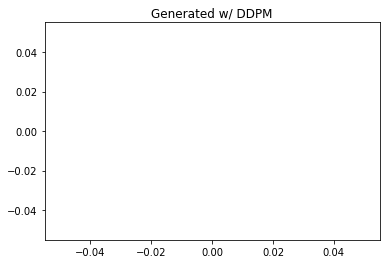

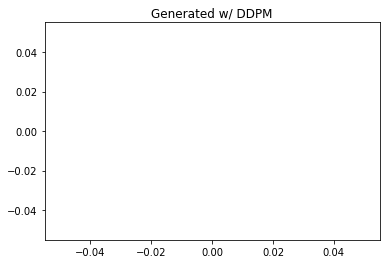

epoch= 11 	 time= 0.4035 min 	 lr= 0.0003 	 loss= 0.0019
epoch= 12 	 time= 0.4372 min 	 lr= 0.0003 	 loss= 0.0018
epoch= 13 	 time= 0.4695 min 	 lr= 0.0003 	 loss= 0.0017
epoch= 14 	 time= 0.5045 min 	 lr= 0.0003 	 loss= 0.0017
epoch= 15 	 time= 0.5416 min 	 lr= 0.0003 	 loss= 0.0023
epoch= 16 	 time= 0.5770 min 	 lr= 0.0003 	 loss= 0.0015
epoch= 17 	 time= 0.6131 min 	 lr= 0.0003 	 loss= 0.0017
Epoch 00019: reducing learning rate of group 0 to 2.8500e-04.
epoch= 18 	 time= 0.6472 min 	 lr= 0.000285 	 loss= 0.0016
epoch= 19 	 time= 0.6846 min 	 lr= 0.000285 	 loss= 0.0015
epoch= 20 	 time= 0.7194 min 	 lr= 0.000285 	 loss= 0.0014


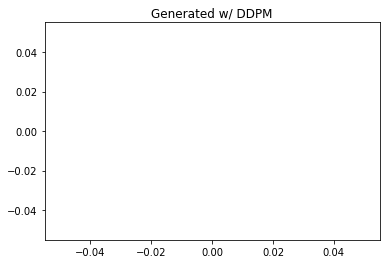

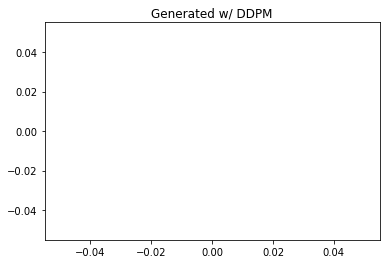

epoch= 21 	 time= 0.7671 min 	 lr= 0.000285 	 loss= 0.0013
epoch= 22 	 time= 0.8036 min 	 lr= 0.000285 	 loss= 0.0014
Epoch 00024: reducing learning rate of group 0 to 2.7075e-04.
epoch= 23 	 time= 0.8414 min 	 lr= 0.00027075 	 loss= 0.0013
epoch= 24 	 time= 0.8791 min 	 lr= 0.00027075 	 loss= 0.0013
epoch= 25 	 time= 0.9167 min 	 lr= 0.00027075 	 loss= 0.0013
epoch= 26 	 time= 0.9542 min 	 lr= 0.00027075 	 loss= 0.0013
epoch= 27 	 time= 0.9890 min 	 lr= 0.00027075 	 loss= 0.0011
epoch= 28 	 time= 1.0208 min 	 lr= 0.00027075 	 loss= 0.0012
epoch= 29 	 time= 1.0526 min 	 lr= 0.00027075 	 loss= 0.0011
epoch= 30 	 time= 1.0842 min 	 lr= 0.00027075 	 loss= 0.0011


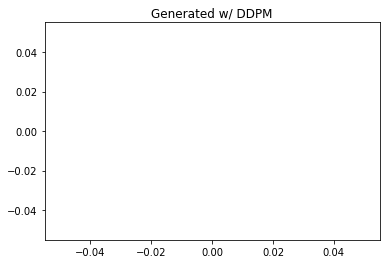

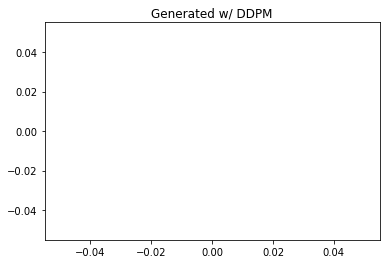

Epoch 00032: reducing learning rate of group 0 to 2.5721e-04.
epoch= 31 	 time= 1.1314 min 	 lr= 0.0002572125 	 loss= 0.0012
epoch= 32 	 time= 1.1653 min 	 lr= 0.0002572125 	 loss= 0.0011
epoch= 33 	 time= 1.2060 min 	 lr= 0.0002572125 	 loss= 0.0010
epoch= 34 	 time= 1.2509 min 	 lr= 0.0002572125 	 loss= 0.0011
Epoch 00036: reducing learning rate of group 0 to 2.4435e-04.
epoch= 35 	 time= 1.2939 min 	 lr= 0.000244351875 	 loss= 0.0011
epoch= 36 	 time= 1.3320 min 	 lr= 0.000244351875 	 loss= 0.0010
epoch= 37 	 time= 1.3716 min 	 lr= 0.000244351875 	 loss= 0.0010
epoch= 38 	 time= 1.4061 min 	 lr= 0.000244351875 	 loss= 0.0011
epoch= 39 	 time= 1.4385 min 	 lr= 0.000244351875 	 loss= 0.0010
epoch= 40 	 time= 1.4737 min 	 lr= 0.000244351875 	 loss= 0.0010


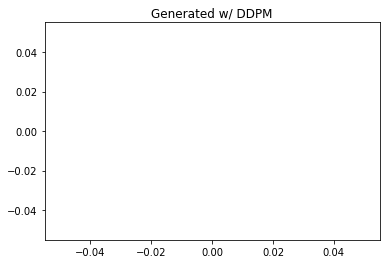

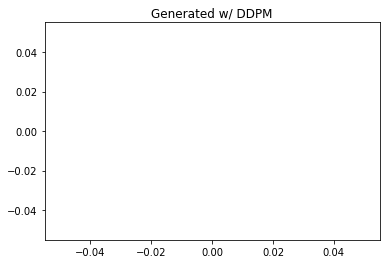

epoch= 41 	 time= 1.5244 min 	 lr= 0.000244351875 	 loss= 0.0009
epoch= 42 	 time= 1.5563 min 	 lr= 0.000244351875 	 loss= 0.0009
epoch= 43 	 time= 1.5884 min 	 lr= 0.000244351875 	 loss= 0.0010
epoch= 44 	 time= 1.6226 min 	 lr= 0.000244351875 	 loss= 0.0009
epoch= 45 	 time= 1.6612 min 	 lr= 0.000244351875 	 loss= 0.0009
epoch= 46 	 time= 1.6997 min 	 lr= 0.000244351875 	 loss= 0.0010
Epoch 00048: reducing learning rate of group 0 to 2.3213e-04.
epoch= 47 	 time= 1.7399 min 	 lr= 0.00023213428124999998 	 loss= 0.0009
epoch= 48 	 time= 1.7792 min 	 lr= 0.00023213428124999998 	 loss= 0.0009
epoch= 49 	 time= 1.8185 min 	 lr= 0.00023213428124999998 	 loss= 0.0010
Epoch 00051: reducing learning rate of group 0 to 2.2053e-04.
epoch= 50 	 time= 1.8528 min 	 lr= 0.00022052756718749997 	 loss= 0.0011


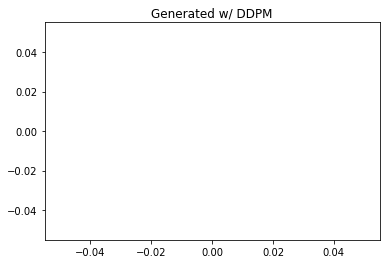

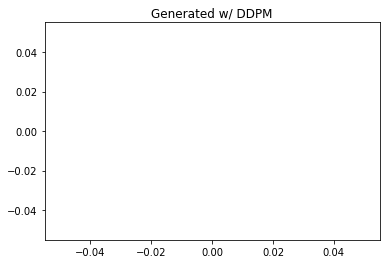

epoch= 51 	 time= 1.9016 min 	 lr= 0.00022052756718749997 	 loss= 0.0008
epoch= 52 	 time= 1.9370 min 	 lr= 0.00022052756718749997 	 loss= 0.0008
epoch= 53 	 time= 1.9753 min 	 lr= 0.00022052756718749997 	 loss= 0.0008
epoch= 54 	 time= 2.0092 min 	 lr= 0.00022052756718749997 	 loss= 0.0008
epoch= 55 	 time= 2.0420 min 	 lr= 0.00022052756718749997 	 loss= 0.0009
Epoch 00057: reducing learning rate of group 0 to 2.0950e-04.
epoch= 56 	 time= 2.0779 min 	 lr= 0.00020950118882812497 	 loss= 0.0008
epoch= 57 	 time= 2.1235 min 	 lr= 0.00020950118882812497 	 loss= 0.0008
epoch= 58 	 time= 2.1699 min 	 lr= 0.00020950118882812497 	 loss= 0.0008
epoch= 59 	 time= 2.2123 min 	 lr= 0.00020950118882812497 	 loss= 0.0008
epoch= 60 	 time= 2.2540 min 	 lr= 0.00020950118882812497 	 loss= 0.0009


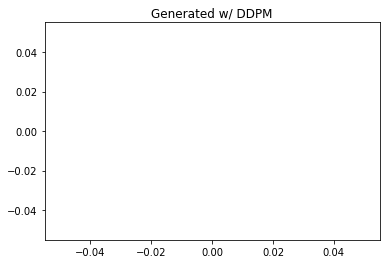

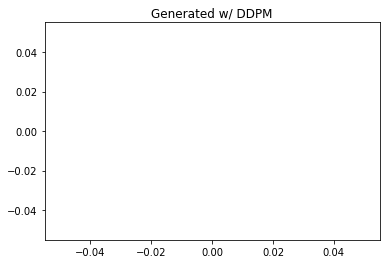

epoch= 61 	 time= 2.3119 min 	 lr= 0.00020950118882812497 	 loss= 0.0008
epoch= 62 	 time= 2.3458 min 	 lr= 0.00020950118882812497 	 loss= 0.0008
epoch= 63 	 time= 2.3815 min 	 lr= 0.00020950118882812497 	 loss= 0.0008
Epoch 00065: reducing learning rate of group 0 to 1.9903e-04.
epoch= 64 	 time= 2.4143 min 	 lr= 0.00019902612938671872 	 loss= 0.0009
epoch= 65 	 time= 2.4481 min 	 lr= 0.00019902612938671872 	 loss= 0.0008
epoch= 66 	 time= 2.4822 min 	 lr= 0.00019902612938671872 	 loss= 0.0007
epoch= 67 	 time= 2.5148 min 	 lr= 0.00019902612938671872 	 loss= 0.0007
epoch= 68 	 time= 2.5589 min 	 lr= 0.00019902612938671872 	 loss= 0.0007
epoch= 69 	 time= 2.6015 min 	 lr= 0.00019902612938671872 	 loss= 0.0007
Epoch 00071: reducing learning rate of group 0 to 1.8907e-04.
epoch= 70 	 time= 2.6458 min 	 lr= 0.00018907482291738277 	 loss= 0.0007


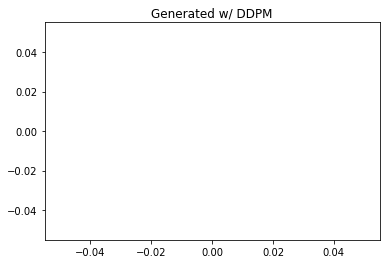

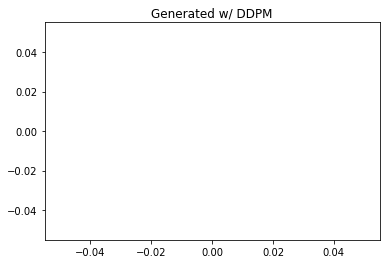

epoch= 71 	 time= 2.7408 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 72 	 time= 2.8142 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 73 	 time= 2.8875 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 74 	 time= 2.9708 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 75 	 time= 3.0539 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 76 	 time= 3.1330 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 77 	 time= 3.2098 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 78 	 time= 3.2813 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 79 	 time= 3.3560 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 80 	 time= 3.4360 min 	 lr= 0.00018907482291738277 	 loss= 0.0007


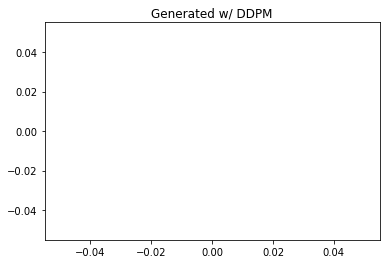

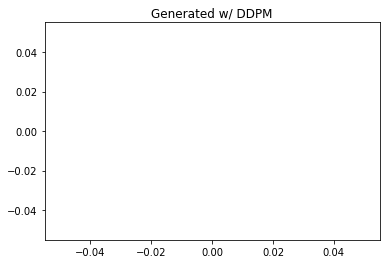

epoch= 81 	 time= 3.5586 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 82 	 time= 3.6159 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 83 	 time= 3.6916 min 	 lr= 0.00018907482291738277 	 loss= 0.0007
epoch= 84 	 time= 3.7664 min 	 lr= 0.00018907482291738277 	 loss= 0.0008
epoch= 85 	 time= 3.8420 min 	 lr= 0.00018907482291738277 	 loss= 0.0006
epoch= 86 	 time= 3.9187 min 	 lr= 0.00018907482291738277 	 loss= 0.0006
epoch= 87 	 time= 3.9951 min 	 lr= 0.00018907482291738277 	 loss= 0.0006
Epoch 00089: reducing learning rate of group 0 to 1.7962e-04.
epoch= 88 	 time= 4.0684 min 	 lr= 0.0001796210817715136 	 loss= 0.0006
epoch= 89 	 time= 4.1451 min 	 lr= 0.0001796210817715136 	 loss= 0.0006
epoch= 90 	 time= 4.2190 min 	 lr= 0.0001796210817715136 	 loss= 0.0006


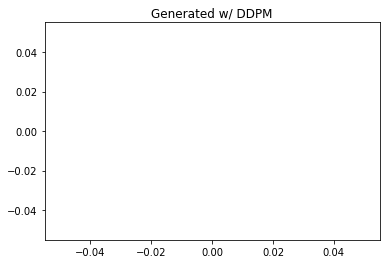

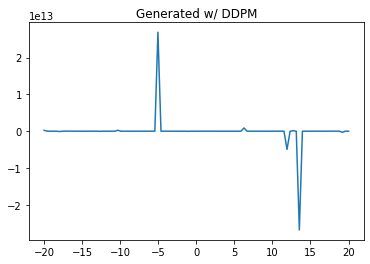

epoch= 91 	 time= 4.3236 min 	 lr= 0.0001796210817715136 	 loss= 0.0006
epoch= 92 	 time= 4.3805 min 	 lr= 0.0001796210817715136 	 loss= 0.0006
epoch= 93 	 time= 4.4555 min 	 lr= 0.0001796210817715136 	 loss= 0.0006
epoch= 94 	 time= 4.5293 min 	 lr= 0.0001796210817715136 	 loss= 0.0006
epoch= 95 	 time= 4.6039 min 	 lr= 0.0001796210817715136 	 loss= 0.0006
epoch= 96 	 time= 4.6815 min 	 lr= 0.0001796210817715136 	 loss= 0.0006
epoch= 97 	 time= 4.7605 min 	 lr= 0.0001796210817715136 	 loss= 0.0006
Epoch 00099: reducing learning rate of group 0 to 1.7064e-04.
epoch= 98 	 time= 4.8377 min 	 lr= 0.00017064002768293793 	 loss= 0.0006
epoch= 99 	 time= 4.9120 min 	 lr= 0.00017064002768293793 	 loss= 0.0006


In [11]:
# Training loop
del net
net = DDPM(num_t, beta_1, beta_T)
net = net.to(device)
_ = display_num_param(net)

# Optimizer
init_lr = 0.0003
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

# Number of mini-batches per epoch
nb_epochs = 100
start = time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0

    shuffled_indices = torch.randperm(N)
    for count in range(0,N,bs):

        idx_data = shuffled_indices[count : count+bs]
        batch_x0 = train_data[idx_data,:].to(device) # [bs, n]
        batch_sample_t = torch.randint(0, num_t, (batch_x0.size(0),)).long().to(device) # random interger in {0,1,...,T-1} [bs]
        bs2, n = batch_x0.size()
        batch_noise_x_t = torch.randn(bs2,n).to(device) # [bs, n]
        x_t = net.forward_process(batch_x0, batch_sample_t, batch_noise_x_t) # [bs, n]
        noise_pred_x_t = net.backward_process(x_t, batch_sample_t) # [bs, n]
        loss_DDPM = torch.nn.MSELoss()(noise_pred_x_t, batch_noise_x_t) 
        loss = loss_DDPM
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
        optimizer.step()
        
        # Compute stats
        running_loss += loss.detach().item()
        num_batches += 1

    # Average stats
    mean_loss = running_loss/num_batches
    scheduler.step(mean_loss)
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', str(elapsed)[:6],'min', '\t lr=', optimizer.param_groups[0]['lr']  ,'\t loss=', str(mean_loss)[:6] )

    # Plot intermediate generated data
    if not epoch%10 and epoch>0:
        x_fake = net.generate_process_ddpm(2)
        plt.plot(x, x_fake[0].detach().cpu()); plt.title("Generated w/ DDPM"); plt.show()
        plt.plot(x, x_fake[1].detach().cpu()); plt.title("Generated w/ DDPM"); plt.show()

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 10**-4: 
      print("\n lr is equal to min lr -- training stopped\n")
      break

 

# Question 3: Generate new data

Go through `def generate_process_ddpm(self, num_mol)`.


batch_x_0 torch.Size([16, 100])


<Figure size 1200x800 with 0 Axes>

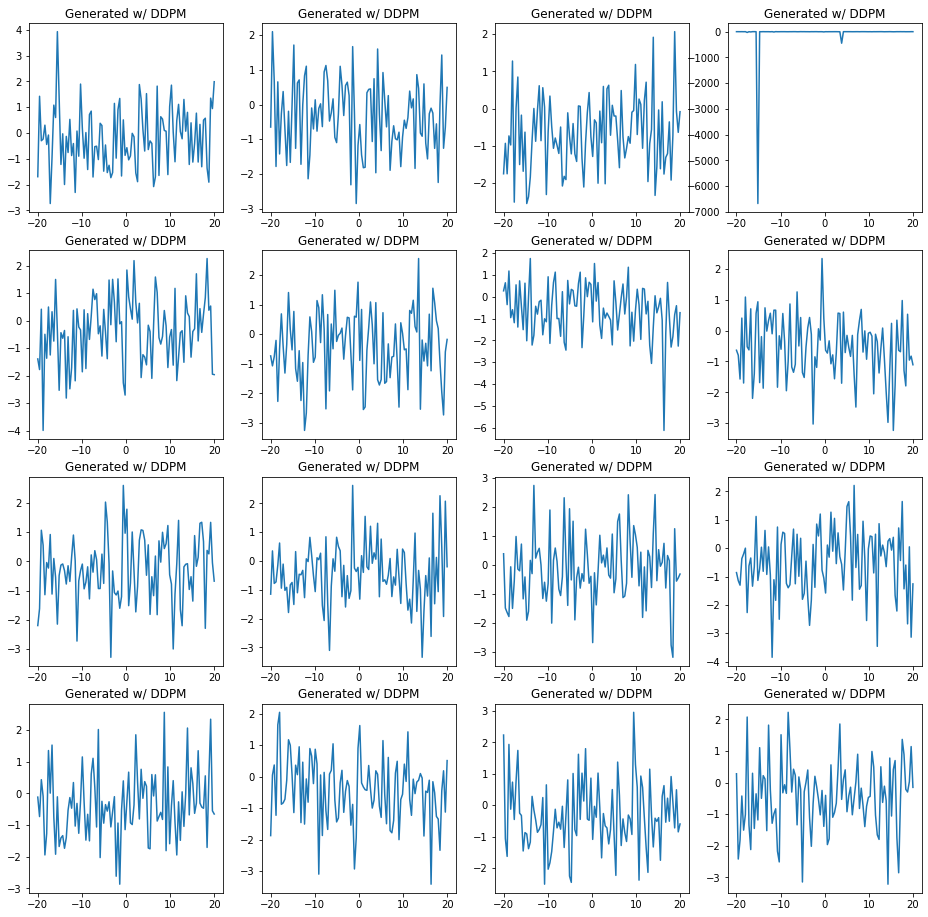

In [12]:
net.eval()
with torch.no_grad():
    num_generated_images = 16
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    batch_x_0 = net.generate_process_ddpm(num_generated_images)
    ###############################################
    # YOUR CODE ENDS
    ############################################### 
    print('batch_x_0',batch_x_0.size())
    batch_x_0 = batch_x_0.cpu()

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=1,0,1; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=2,0,2; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=3,0,3; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=0,1+0,4; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=1,1+0,5; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=2,1+0,6; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=3,1+0,7; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=0,2+0,8; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=1,2+0,9; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=2,2+0,10; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=3,2+0,11; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=0,3+0,12; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=1,3+0,13; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=2,3+0,14; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=3,3+0,15; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
plt.show()
